# Importing all the dependencies

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Saving all the constants

In [10]:
# Saving all the constants at one place so that we can access it whenever we require
IMG_SHAPE = (224, 224)
EPOCHS = 5
BATCH_SIZE = 32
TRAIN_DIR = "10_food_classes_10_percent/train/"
TEST_DIR = "10_food_classes_10_percent/test/"
TENSORBOARD_DIR = 'tensorflow_hub'
MOBILENET_URL = "https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/100-224-feature-vector/versions/1"
CLASS_MODE = 'categorical'

# Creating custom functions

## Accuracy-Loss Curve

In [4]:
def plot_loss_curve(history):
    '''
    This function gives you loss and accuracy curve of the model after training based on its history

    Args:
        history: History of the model

    Return:
        Matplotlin graphs of loss and accuracy curve
    '''

    #extracting data for plotting
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    #Plotting loss curve
    plt.figure()
    plt.plot(range(EPOCHS), loss, label = 'Training Loss value')
    plt.plot(range(EPOCHS), val_loss, label = 'Testing Loss value')
    plt.title("Loss curve")
    plt.legend()

    #Plotting accuracy curve
    plt.figure()
    plt.plot(range(EPOCHS), accuracy, label= "Training accuracy")
    plt.plot(range(EPOCHS), val_accuracy, label= "Testing accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()

## Tensorboard Callback function

In [23]:
import datetime

def tensorboard_callback(dir_name, experiment_name):
    '''
    This function creates a log directory to store the tensorboard callback

    Args:
        dir_name (str): The directory name where the logs are stored
        experiment_name (str): The experiment name on which the log is being saved

    Return:
        A tensorboard log file
    '''

    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= log_dir)

    print(f"Saviong log files to {log_dir}")

    return tensorboard_callback

## Create model function

In [13]:
def create_model(model_url, num_classes= 10):
    '''
    This function creates a model along with the pretrained feature extractor from the link provided

    Args:
        model_url (str): The link to the feature extractor from tensorflow hub
        num_classes (int): Number of classes in the dataset

    Return:
        An uncompiled model
    '''

    #Extracting the feature extractor from tensorflow hub
    feature_extractor = hub.KerasLayer(model_url,
                                       trainable= False,
                                       name= "feature_extractor",
                                       input_shape= IMG_SHAPE + (3, ))
    
    model = tf.keras.Sequential([
        feature_extractor,
        layers.Dense(num_classes, activation= 'softmax', name= 'output_layer')
    ])

    return model

# Load the data

We've set all the necessary information we require for creating the model.

Let's proceed with loading the data, preprocess it and finally train our model.

In [9]:
# Creating data generator for both training and testing set

train_datagen = ImageDataGenerator(rescale= 1/255.)
test_datagen = ImageDataGenerator(rescale= 1/255.)

In [11]:
# Loading the data

train_data = train_datagen.flow_from_directory(TRAIN_DIR,
                                               target_size= IMG_SHAPE,
                                               batch_size= BATCH_SIZE,
                                               class_mode= CLASS_MODE)

test_data = test_datagen.flow_from_directory(TEST_DIR,
                                             target_size= IMG_SHAPE,
                                             batch_size= BATCH_SIZE,
                                             class_mode= CLASS_MODE)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [24]:
# Creating model with MobileNet feature extractor
mobilenet_model = create_model(MOBILENET_URL, 10)

In [25]:
# Getting the summary of the model
mobilenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor (KerasLay  (None, 1280)             2257984   
 er)                                                             
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
# Compiling the model
mobilenet_model.compile(loss= tf.keras.losses.CategoricalCrossentropy(),
                        optimizer= tf.keras.optimizers.Adam(),
                        metrics= ['accuracy'])

In [27]:
#Fitting the model
history_mobilenet = mobilenet_model.fit(train_data,
                                        epochs= EPOCHS,
                                        steps_per_epoch= len(train_data),
                                        validation_data= test_data,
                                        validation_steps= len(test_data),
                                        callbacks= [tensorboard_callback(TENSORBOARD_DIR, 'mobilenetV2100')])

Saviong log files to tensorflow_hub/mobilenetV2100/20240210-002916
Epoch 1/5
24/24 [==============================] - 17s 674ms/step - loss: 1.9092 - accuracy: 0.3440 - val_loss: 1.2836 - val_accuracy: 0.6264
Epoch 2/5
24/24 [==============================] - 15s 651ms/step - loss: 1.0160 - accuracy: 0.7173 - val_loss: 0.8888 - val_accuracy: 0.7276
Epoch 3/5
24/24 [==============================] - 16s 675ms/step - loss: 0.7113 - accuracy: 0.8040 - val_loss: 0.7433 - val_accuracy: 0.7716
Epoch 4/5
24/24 [==============================] - 16s 667ms/step - loss: 0.5638 - accuracy: 0.8573 - val_loss: 0.6899 - val_accuracy: 0.7828
Epoch 5/5
24/24 [==============================] - 16s 668ms/step - loss: 0.4803 - accuracy: 0.8960 - val_loss: 0.6453 - val_accuracy: 0.7948


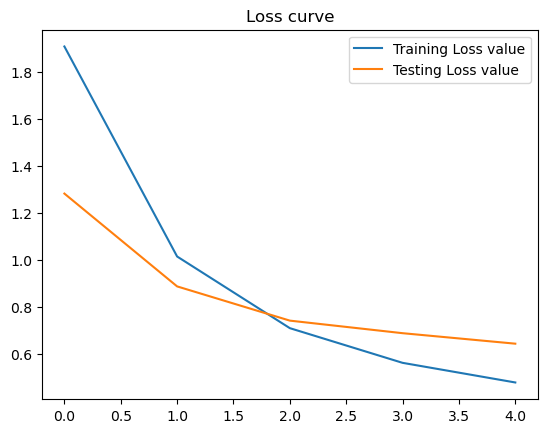

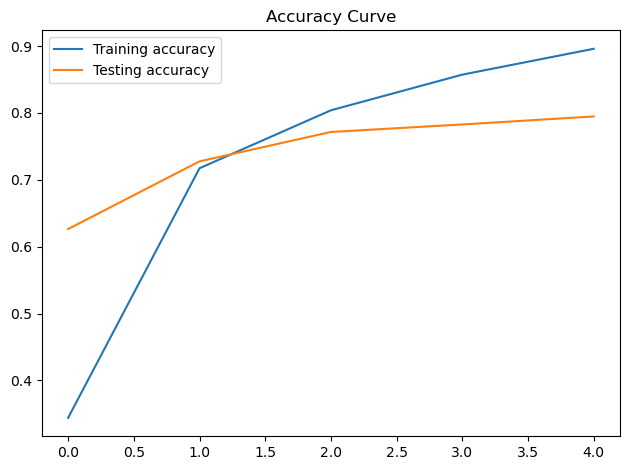

In [28]:
plot_loss_curve(history_mobilenet)